In [1]:
import dask.array as da
from dask.distributed import Client
import numpy as np
import matplotlib.pyplot as plt

from functions import kernel_est_funcs as kef
from functions import conn_inf_funcs as cif
#from functions import remove_outliers as ro
import brunel_network as bn

import h5py
import json


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0
 Built: Aug 27 2024 04:33:06

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
ground_truth = bn.BrunelNetwork()
ground_truth.setup_kernel()
ground_truth.setup_elements()
ground_truth.connect_elements()
ground_truth.simulate()


Oct 24 17:05:35 SimulationManager::set_status [Info]: Starting Brunel network simulation:  1729782335.0730317

    Temporal resolution changed from 0.1 to 0.1 ms.
Simulation finished:  1729782335.3465002
Brunel network simulation finished
Number of neurons: 500
Number of synapses: 26100
Excitatory rate: %.2f Hz
Inhibitory rate: %.2f Hz
Simulation time: 0.2734684944152832

Oct 24 17:05:35 NodeManager::prepare_nodes [Info]: 
    Preparing 620 nodes for simulation.

Oct 24 17:05:35 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 620
    Simulation time (ms): 1000
    Number of OpenMP threads: 20
    Not using MPI

[ 100% ] Model time: 1000.0 ms, Real-time factor: 0.0685, Real-time factor: 0.1185

Oct 24 17:05:35 SimulationManager::run [Info]: 
    Simulation finished.


In [3]:
_, conns = ground_truth.record_data()
sp_file, conn_file = ground_truth.save_data()

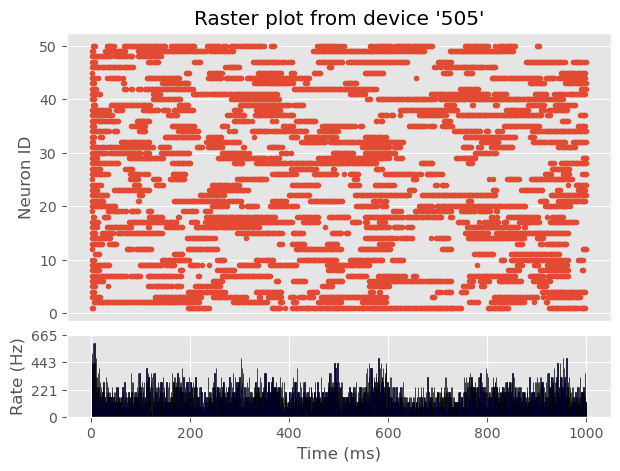

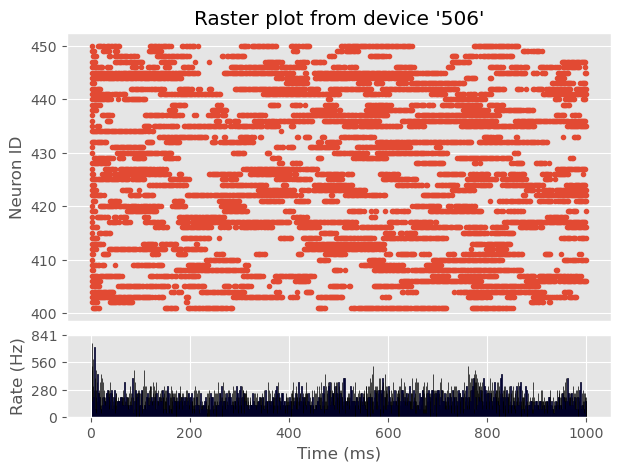

In [4]:
ground_truth.raster()

In [5]:
spikes_hdf = h5py.File(sp_file, 'r')
print(spikes_hdf.keys())

<KeysViewHDF5 ['spikes_trains']>


In [6]:
spikes_trains = spikes_hdf['spikes_trains']   
spikes_trains.shape

(498, 1000)

In [7]:
client = Client()

dashboard_link = client.dashboard_link
print(f"Dask Dashboard: {dashboard_link}")
import webbrowser
# Optionally, open it automatically in the default browser
webbrowser.open(dashboard_link)

rec_length = json.load(open('network_config.json'))['sim_params']['sim_length']
dask_array = da.from_array(spikes_trains, chunks=('auto', rec_length))
pr1 = dask_array.map_blocks(kef.dask_calcium, dtype=dask_array.dtype)
pr2 = pr1.map_blocks(kef.dask_smooth, dtype=dask_array.dtype)
result = pr2.compute()

Dask Dashboard: http://127.0.0.1:8787/status


In [8]:
result.shape

(498, 900)

In [15]:
def dask_calcium(spikes, tau=100):

    N = np.shape(spikes)[0]
    wup_time = 100
    spikes = spikes[:, wup_time:]
    sim_dur = np.shape(spikes)[1]
    
    noise_intra = np.random.normal(0, 0.01, (N, sim_dur))
    spikes_noisy = spikes + noise_intra

    calcium = np.zeros((N, sim_dur))
    calcium_nsp = np.zeros((N, sim_dur))
    dt = 1
    const_A = np.exp((-1/tau)*dt)

    calcium[:, 0] = spikes[:, 0]
    calcium_nsp[:, 0] = spikes[:, 0]

    for t in range(1, sim_dur):
        calcium[:, t] = const_A*calcium[:, t-1] + spikes[:, t]

    for t in range(1, sim_dur):
        calcium_nsp[:, t] = const_A*calcium_nsp[:, t-1] + spikes_noisy[:, t]

    noise_recording = np.random.normal(0,1, (N, sim_dur))
    calcium_noisy = calcium + noise_recording
    calcium_nsp_noisy = calcium_nsp + noise_recording

    return calcium_nsp_noisy

In [12]:
from sklearn.linear_model import LinearRegression

def conn_inf_LR(conn_matrix, signals, lag=10):
    
    G = np.load(conn_matrix)
    G = G - (np.diag(np.diag(G)))

    Y = signals[:, lag:]
    Y_prime = signals[:, :-lag]

    yk = Y.T
    y_k = Y_prime.T
    
    reg = LinearRegression(n_jobs=-1).fit(y_k, yk)
    A = reg.coef_
    A = A - (np.diag(np.diag(A)))
    
    #corr_G_A = np.corrcoef(G.flatten(), A.flatten())[0, 1]

    return A

In [13]:
est_conn = conn_inf_LR(conn_file, result)
print(est_conn.shape)
#print(corr_coef)
np.save('est_'+conn_file, est_conn)

(498, 498)


In [14]:
test = np.load(conn_file)
test.shape

(500, 500)